# GPU Check

In [1]:
import tensorflow as tf
import torch

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15443778851019698172
 xla_global_id: -1]

In [3]:
# GPU 사용 가능 -> True, GPU 사용 불가 -> False
print(torch.cuda.is_available())

False


In [4]:
# 사용 가능 GPU 개수 체크
print(torch.cuda.device_count())

0


# Module Import

In [89]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow import keras
from keras import optimizers
from keras import models
from keras import layers
from keras import optimizers
from keras import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array

from keras.applications import efficientnet

# Data Load

In [90]:
batch = 32
epochs = 40

(500, 500, 3)


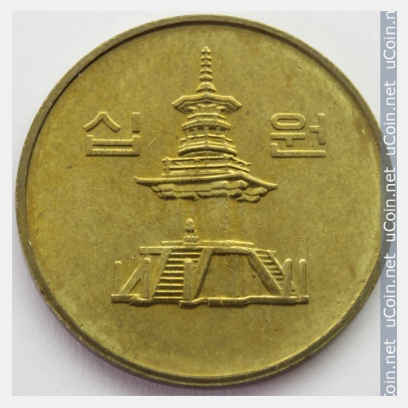

In [91]:
img = cv2.imread('./korean_coins/train/10/002__10 Won_south_korea.jpg')
print(img.shape)
plt.imshow(img[:,:,::-1])
plt.xticks([])
plt.yticks([])
plt.show()

In [92]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    shear_range=0.2,
                    zoom_range=0.4,
                    horizontal_flip=True)
test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [93]:
train_generator = train_datagen.flow_from_directory(
                    './korean_coins/train',
                    batch_size=batch,
                    target_size=(256, 256),     # Default
                    class_mode='sparse',
                    color_mode='rgb',
                    shuffle=True)
test_generator = test_datagen.flow_from_directory(
                    './korean_coins/test',
                    batch_size=batch,
                    target_size=(256, 256),
                    class_mode='sparse',
                    color_mode='rgb',
                    shuffle=False)

Found 166 images belonging to 6 classes.
Found 24 images belonging to 6 classes.


## view Data

In [94]:
imgs = train_generator.__getitem__(0)

In [96]:
print(imgs[0].shape)
print(imgs[1].shape)

(32, 256, 256, 3)
(32,)


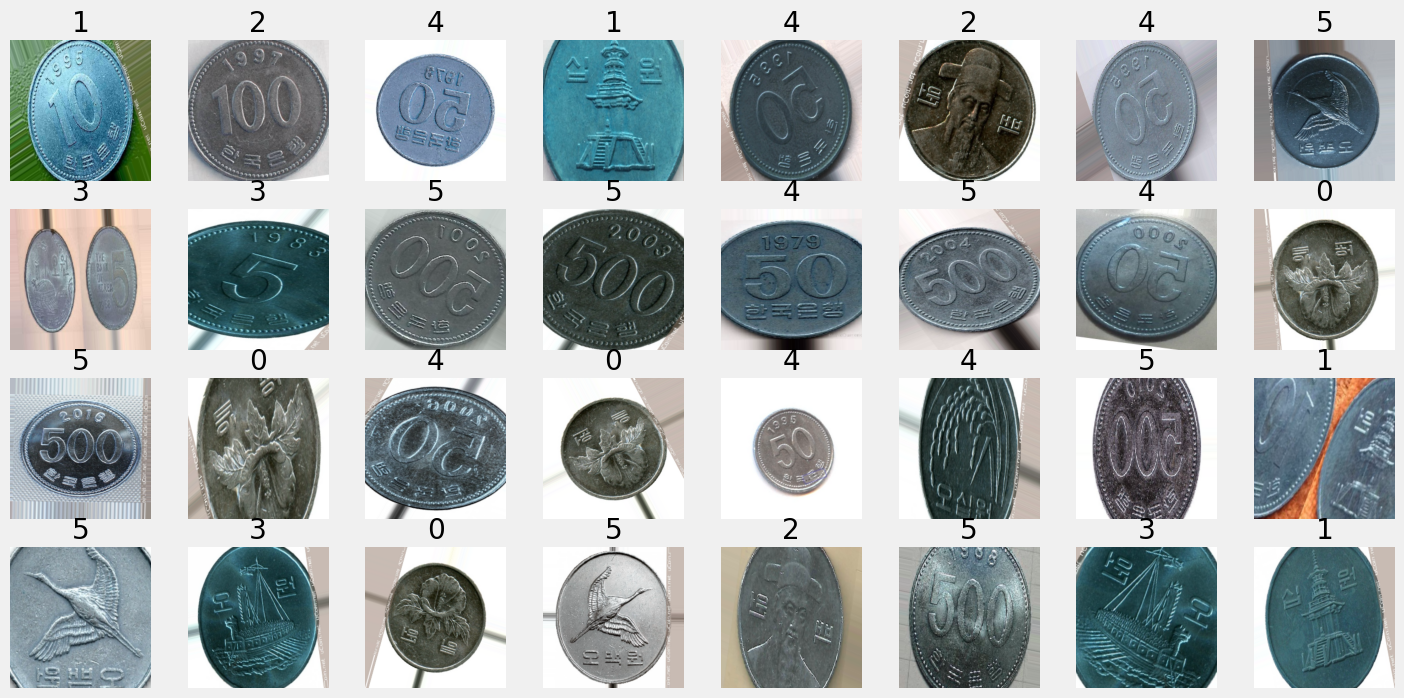

In [97]:
plt.figure(figsize=(16, 8))
for i, img in enumerate(imgs[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%d' % imgs[1][i])
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

# create Classifier Model

In [98]:
img_shape=(256, 256, 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

NameError: name 'regularizers' is not defined

In [ ]:
conv_layers = efficientnet.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3), pooling='max')
conv_layers.trainable = True

model = keras.Sequential()

model.add(conv_layers)
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=.4))
model.add(Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=['acc'])
model.summary()

# Model Fit

In [99]:
history = model.fit(
      train_generator,
      validation_data=test_generator,
      epochs=50
)

Epoch 1/50
6/6 [==============================] - 46s 9s/step - loss: 0.4899 - acc: 0.8675 - val_loss: 3.0200 - val_acc: 0.1667
Epoch 2/50
6/6 [==============================] - 49s 9s/step - loss: 0.5759 - acc: 0.8795 - val_loss: 2.7707 - val_acc: 0.1667
Epoch 3/50
6/6 [==============================] - 49s 8s/step - loss: 0.3036 - acc: 0.9036 - val_loss: 3.2097 - val_acc: 0.1667
Epoch 4/50
6/6 [==============================] - 48s 8s/step - loss: 0.4934 - acc: 0.8735 - val_loss: 3.1780 - val_acc: 0.1667
Epoch 5/50
6/6 [==============================] - 48s 9s/step - loss: 0.9782 - acc: 0.8675 - val_loss: 2.5945 - val_acc: 0.1667
Epoch 6/50
6/6 [==============================] - 50s 8s/step - loss: 0.5279 - acc: 0.8735 - val_loss: 2.6281 - val_acc: 0.1667
Epoch 7/50
6/6 [==============================] - 50s 10s/step - loss: 0.5931 - acc: 0.7892 - val_loss: 4.7441 - val_acc: 0.1667
Epoch 8/50
6/6 [==============================] - 50s 8s/step - loss: 0.5366 - acc: 0.8554 - val_loss: 

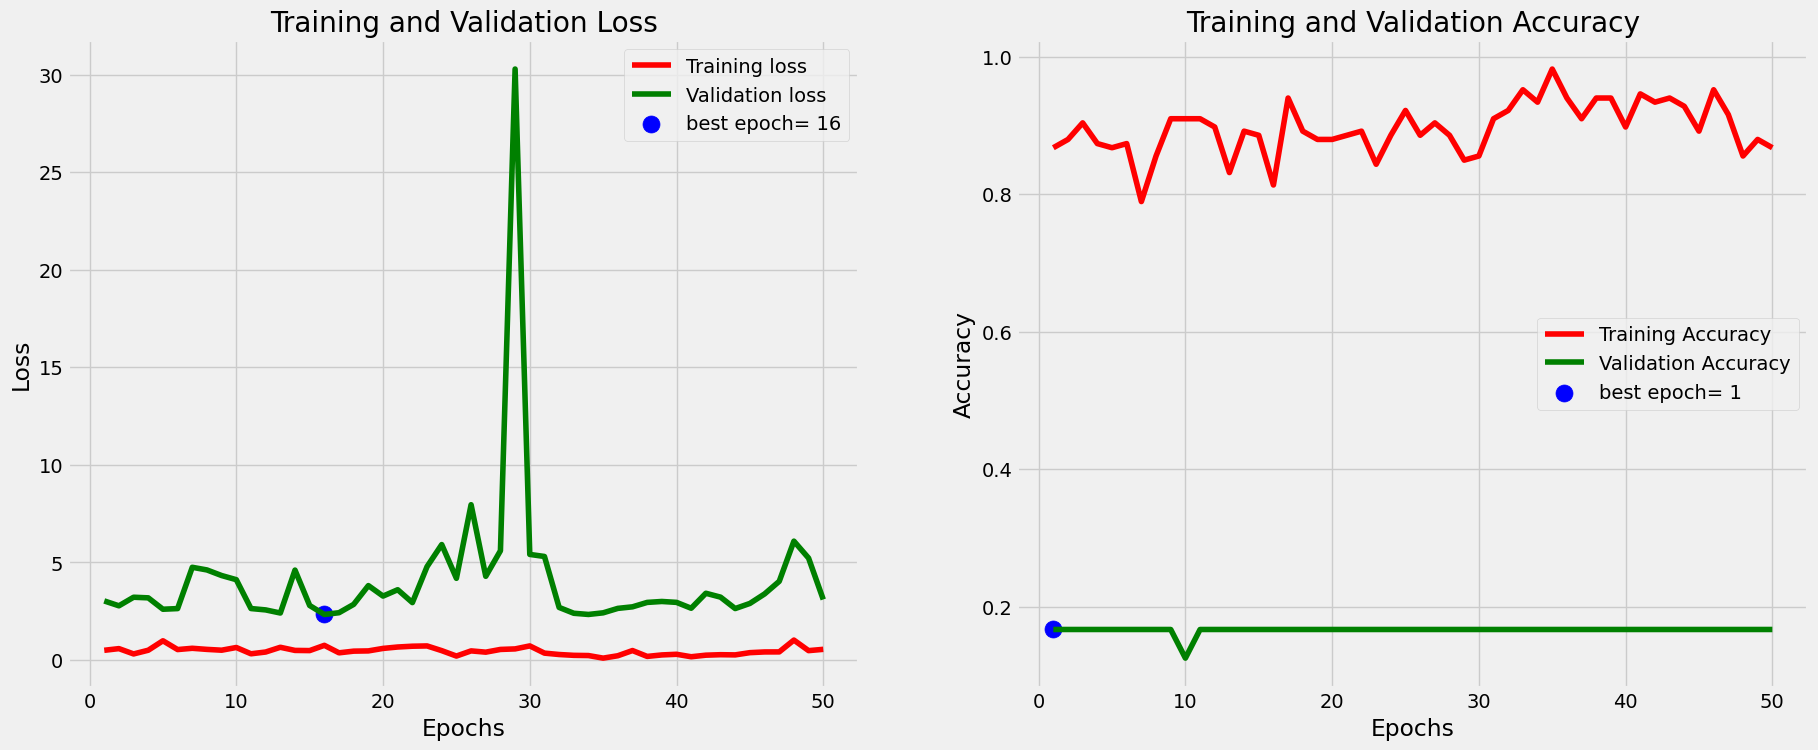

In [101]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['acc']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_acc']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

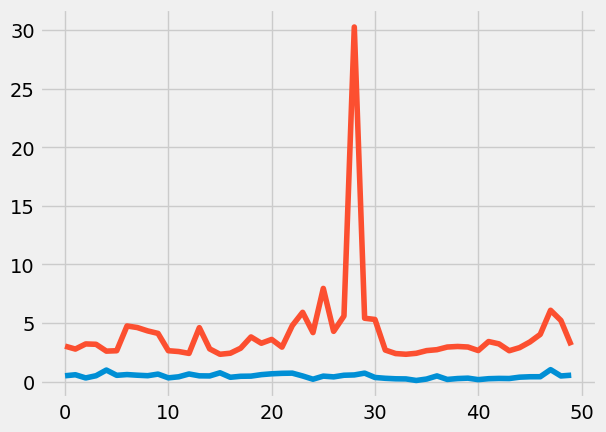

1/1 [==============================] - 1s 1s/step - loss: 3.0942 - acc: 0.1667
loss= 3.0942490100860596
acc= 0.1666666716337204


In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_generator)
print("loss=", loss)
print("acc=", acc)

1/1 [==============================] - 3s 3s/step


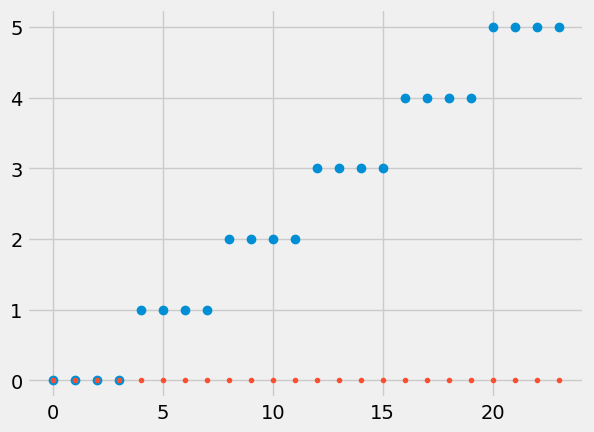

In [104]:
batch_x, batch_y = test_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()

In [105]:
custom_labels = list(test_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])

label category index = 0.0
predicted category index = 0
predicted category name = 1
